In [56]:
from datetime import timedelta, date, datetime

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [88]:
daily_df = pd.read_csv('data/clean_data/daily.csv').set_index('id')


In [89]:
# prcoess time columns
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['year'] = daily_df['date'].dt.year
daily_df['weekofyear'] = daily_df['date'].dt.isocalendar().week

In [90]:
# limit to one store
store_df = daily_df.loc[daily_df['store_id'] == 2, :]

In [91]:
weekly_df = store_df.groupby(['year', 'weekofyear']).agg(
    sales=("sales", "sum"),
    orders=("orders", "sum"),
    discounts=("discount", "sum"),
    holidays=("holiday", "sum")
    ).reset_index()
weekly_df['week'] = weekly_df['year'].astype(str) + "-" + weekly_df['weekofyear'].astype(str)

<AxesSubplot: xlabel='week', ylabel='sales'>

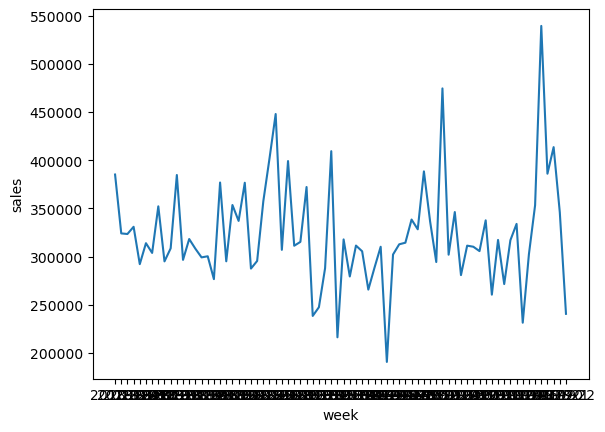

In [92]:
sns.lineplot(weekly_df, x="week", y="sales")

In [54]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_df['sales'])
print('p-value: %f' % result[1])

p-value: 0.000000


In [93]:
# add lags
how_many_lags = 2
lagged_df = weekly_df.copy()
for t in range(1, how_many_lags + 1):
    lagged_df[f'sales-{t}'] = lagged_df['sales'].shift(t)
lagged_df.head()

,year,weekofyear,sales,orders,discounts,holidays,week,sales-1,sales-2
0,2018,1,385064.52,524,5,1,2018-1,NaN,NaN
1,2018,2,324000.00,454,2,1,2018-2,385064.52,NaN
2,2018,3,323385.00,509,3,0,2018-3,324000.00,385064.52
3,2018,4,330865.35,521,4,2,2018-4,323385.00,324000.00
4,2018,5,292106.04,502,1,1,2018-5,330865.35,323385.00


In [109]:
lagged_df = lagged_df.iloc[how_many_lags:, :]
features = [f"sales-{t}" for t in range(1, how_many_lags + 1)] + ["holidays", "discounts"]
lr = RandomForestRegressor()
lr.fit(X=lagged_df[features], y=lagged_df['sales'])
print(list(zip(lr.feature_names_in_, lr.feature_importances_)))
#print(lr.intercept_)

['sales-1', 'sales-2', 'holidays', 'discounts']
[('sales-1', 0.2524289419300087), ('sales-2', 0.18008900538037473), ('holidays', 0.15368628432528983), ('discounts', 0.4137957683643267)]


AttributeError: 'RandomForestRegressor' object has no attribute 'intercept_'

In [107]:
#print(lagged_df.tail())
pred_week = lagged_df.iloc[-1:,:][['sales', 'sales-1']].to_numpy()
pred_sales = lr.predict(pred_week)
print(pred_sales)

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but RandomForestRegressor is expecting 4 features as input.

In [87]:
lagged_df.tail()

,year,weekofyear,sales,orders,discounts,holidays,week,sales-1,sales-2,sales-3,sales-4,sales-5
69,2019,18,539217.00,808,5,0,2019-18,353235.00,302464.05,231367.98,333866.88,316956.00
70,2019,19,385950.00,618,1,1,2019-19,539217.00,353235.00,302464.05,231367.98,333866.88
71,2019,20,413475.72,631,4,1,2019-20,385950.00,539217.00,353235.00,302464.05,231367.98
72,2019,21,345834.00,537,3,0,2019-21,413475.72,385950.00,539217.00,353235.00,302464.05
73,2019,22,240584.49,374,2,1,2019-22,345834.00,413475.72,385950.00,539217.00,353235.00


In [9]:
dummy = pd.get_dummies(final_data[['week', 'store_type', 'location_type', 'region_code']], drop_first=True)
final_data = pd.concat([final_data, dummy], axis=1)
finaldf = final_data.drop(columns =['date', 'store_type', 'location_type', 'region_code'], axis=1)
finaldf = finaldf.reset_index(drop=True)
finaldf.head()

/var/folders/cb/7tm32xh579bd23nj5kz1sydc0000gp/T/ipykernel_23723/4143630090.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  final_data['week'] = final_data['date'].dt.week


,store_id,holiday,discount,orders,sales,t-54,t-53,t-52,t-51,t-50,...,store_type_S2,store_type_S3,store_type_S4,location_type_L2,location_type_L3,location_type_L4,location_type_L5,region_code_R2,region_code_R3,region_code_R4
0,204,1,1,29,22662.12,7011.84,51789.12,36868.20,19715.16,45614.52,...,0,0,1,0,0,0,0,0,1,0
1,202,1,1,91,59368.38,51789.12,36868.20,19715.16,45614.52,34211.22,...,0,0,1,1,0,0,0,1,0,0
2,201,1,1,31,31782.36,36868.20,19715.16,45614.52,34211.22,35352.66,...,0,0,1,0,0,0,0,0,0,0
3,200,1,1,35,30574.44,19715.16,45614.52,34211.22,35352.66,52650.00,...,1,0,0,0,0,0,0,1,0,0
4,199,1,1,78,60523.86,45614.52,34211.22,35352.66,52650.00,42633.78,...,0,0,0,0,0,0,0,0,0,1
